In [4]:
import numpy as np
import seaborn as sns
import scipy

import matplotlib.pyplot as plt
import numpy.linalg as la
from sklearn.datasets import load_svmlight_file

from optimizers import Gd, Nesterov, Ad_grad, Ad_grad_accel, SRC
from loss_functions import cubic_loss, cubic_gradient, logistic_gradient

sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
data_path = './datasets/covtype.bz2'
markers = [',', 'o', '*', 'D']
labels = ['GD', 'Nesterov', 'AdGD', 'AdGD-accel']

it_max = 1000

In [8]:
from sklearn.utils.extmath import safe_sparse_dot

def logistic_hessian(w, X, y, l2):
    activation = scipy.special.expit(safe_sparse_dot(X, w, dense_output=True).ravel())
    weights = activation * (1 - activation)
    X_weights = X.T * weights
    return X_weights @ X + l2 * np.eye(len(w))


In [6]:
def logistic_smoothness(X):
    return 0.25 * np.max(la.eigvalsh(X.T @ X / X.shape[0]))



In [9]:
data = load_svmlight_file(data_path)
X, y = data[0].toarray(), data[1]
if (np.unique(y) == [1, 2]).all():
    # Loss functions support only labels from {0, 1}
    y -= 1
n, d = X.shape
L = logistic_smoothness(X)
scale = L * n
l2 = 0

w0 = np.zeros(d)
g = logistic_gradient(w0, X, y, l2, normalize=False)
H = logistic_hessian(w0, X, y, l2)

# The value of M should be chosen proportionally to L and n, but instead
# we use 'scale' variable when computing gradients and loss values
# the value M is slightly different from the one used in the original submission
M = 100

def loss_func(w):
    return cubic_loss(w, H, g, M, scale)

def grad_func(w):
    return cubic_gradient(w, H, g, M, scale)



In [10]:
lrs = np.logspace(-1, 1, 10)
losses = []
#tune the stepsize
for lr_gd in lrs:
    gd = Gd(lr=lr_gd, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
    gd.run(w0=w0)
    gd.compute_loss_on_iterates()
    print(lr_gd, gd.losses[-1])
    losses.append(gd.losses[-1])
lr_gd = lrs[np.nanargmin(losses)]
gd = Gd(lr=lr_gd, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
gd.run(w0=w0)



0.1 -7012.272981576851
0.16681005372000587 -7020.912374944218
0.2782559402207124 -7022.027574195588
0.46415888336127786 -7022.059706033251
0.774263682681127 -7022.059808143568
1.291549665014884 -7022.059808156091
2.1544346900318834 nan
3.593813663804626 inf
5.994842503189409 nan
10.0 nan


/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/loss_functions.py:91: RuntimeWarning: invalid value encountered in matmul
  return (g + H @ w) / scale + M / 2 * w * la.norm(w)
/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/loss_functions.py:84: RuntimeWarning: invalid value encountered in matmul
  return w @ g + 0.5 * H @ w @ w + scale * M / 6 * la.norm(w) ** 3
/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/loss_functions.py:84: RuntimeWarning: overflow encountered in matmul
  return w @ g + 0.5 * H @ w @ w + scale * M / 6 * la.norm(w) ** 3


In [11]:
lrs = np.logspace(-1, 1, 10)
losses = []
#tune the stepsize
for lr_nest in lrs:
    nest = Nesterov(lr=lr_nest, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
    nest.run(w0=w0)
    nest.compute_loss_on_iterates()
    print(lr_nest, nest.losses[-1])
    losses.append(nest.losses[-1])
lr_nest = lrs[np.nanargmin(losses)]
nest = Nesterov(lr=lr_nest, loss_func=loss_func, grad_func=grad_func, it_max=it_max)
nest.run(w0=w0)



0.1 -7022.059126745661
0.16681005372000587 -7022.059603183143
0.2782559402207124 -7022.059785274788
0.46415888336127786 -7022.059808044546
0.774263682681127 -7022.059808154689
1.291549665014884 -7022.059808156082
2.1544346900318834 inf
3.593813663804626 inf
5.994842503189409 inf
10.0 nan


/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/loss_functions.py:91: RuntimeWarning: overflow encountered in matmul
  return (g + H @ w) / scale + M / 2 * w * la.norm(w)
/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/loss_functions.py:84: RuntimeWarning: overflow encountered in double_scalars
  return w @ g + 0.5 * H @ w @ w + scale * M / 6 * la.norm(w) ** 3


In [12]:
adgd = Ad_grad(loss_func=loss_func, grad_func=grad_func, eps=0, it_max=it_max)
adgd.run(w0=w0)



/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/optimizers.py:86: RuntimeWarning: invalid value encountered in double_scalars
  L = la.norm(self.grad - self.grad_old) / la.norm(self.w - self.w_old)
/Users/valentyn.boreiko@ibm.com/master_thesis_project/code/cubic_src/optimizers.py:90: RuntimeWarning: divide by zero encountered in double_scalars
  lr_new = min(np.sqrt(1 + self.theta) * self.lr, self.eps / self.lr + 0.5 / L)


In [14]:
ad_acc = Ad_grad_accel(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
ad_acc.run(w0=w0)


In [ ]:
src = SRC(loss_func=loss_func, grad_func=grad_func, it_max=it_max)
src.run(w0=w0)

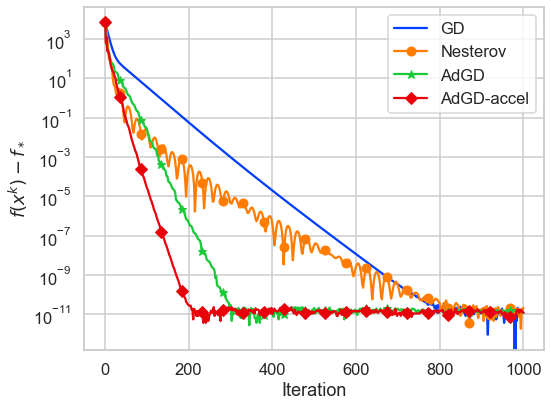

In [15]:
optimizers = [gd, nest, adgd, ad_acc]
for opt, marker in zip(optimizers, markers):
    opt.compute_loss_on_iterates()
f_star = np.min([np.min(opt.losses) for opt in optimizers])

plt.figure(figsize=(8, 6))
for opt, marker, label in zip(optimizers, markers, labels):
    opt.plot_losses(marker=marker, f_star=f_star, label=label)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$f(x^k) - f_*$')
plt.legend() 
plt.tight_layout()
plt.show()



